In [2]:
import pandas as pd
# importing/instantiating all the csv's in case I want to use any of the other data as well
# main DF
df = pd.read_csv('C:/users/Stewa/Documents/Downloads/steam-store-games/steam.csv')
df_clean = df.dropna()

In [3]:
# make my target and features
target = 'price'
features = ['english', 'developer', 'publisher', 'platforms', 'required_age',
            'categories', 'genres', 'steamspy_tags', 'achievements', 'positive_ratings',
            'negative_ratings',	'average_playtime', 'median_playtime', 'owners']

# break up my dataset
# first, I need to cast release_date to dt format
df_clean['release_date'] = pd.to_datetime(df_clean['release_date'], infer_datetime_format=True)
train = df_clean.loc[(df_clean['release_date'] <= pd.datetime(2014,12,31)) 
                     & (df_clean['release_date'] >= pd.datetime(1997,1,1))]

val = df_clean.loc[(df_clean['release_date'] >= pd.datetime(2015,1,1))
                   & (df_clean['release_date'] <= pd.datetime(2016,12,31))] 

test = df_clean.loc[(df_clean['release_date'] >= pd.datetime(2017,1,1))
                   & (df_clean['release_date'] <= pd.datetime(2019,12,31))]

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

C:\Users\stewa\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [4]:
# create pre-encoded versions of the X_'s
import category_encoders as ce
o_encoder = ce.OrdinalEncoder()
X_train_enc = o_encoder.fit_transform(X_train)
X_test_enc = o_encoder.transform(X_test)
X_val_enc = o_encoder.transform(X_val)
# verify that it works
X_train_enc

,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners
0,1,1,1,1,0,1,1,1,0.0,124534.0,3339.0,17612.0,317.0,1
1,1,1,1,1,0,1,1,1,0.0,3318.0,633.0,277.0,62.0,2
2,1,1,1,1,0,2,1,2,0.0,3416.0,398.0,187.0,34.0,2
3,1,1,1,1,0,1,1,1,0.0,1273.0,267.0,258.0,184.0,2
4,1,2,1,1,0,3,1,3,0.0,5250.0,288.0,624.0,415.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,1,2027,1347,3,0,740,42,1068,12.0,102.0,97.0,55.0,55.0,7
4409,1,2028,210,2,0,83,262,1881,17.0,510.0,107.0,14.0,14.0,12
4422,1,1630,1078,1,0,654,63,1882,72.0,1719.0,50.0,0.0,0.0,10
4427,1,1630,1078,1,0,741,63,1883,37.0,108.0,24.0,0.0,0.0,13


In [6]:
# first, lets grab a baseline RMSE
import numpy as np
# get a baseline prediction
baseline = df_clean.price.mean()
# sum of squared errors for the baseline
sse_baseline = np.sum((df_clean.price - baseline)**2)
# next i need to find the MSE(mean squared error)
n = len(df_clean.price)
mse_baseline = sse_baseline / n
# find the root of Mean Squared Error by taking the square-root of the MSE
rmse_baseline = np.sqrt(mse_baseline)

rmse_baseline
#this should be an easy one to beat :O thats sketchily high

6.993591621815642

In [7]:
# lets start with a quick linear regression model
# import linreg and mse
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# instantiate it
linreg = LinearRegression()

# fit the model
linreg.fit(X_train_enc, y_train)
y_pred = linreg.predict(X_train_enc)

# create the mse and then rmse
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print('RMSE of linreg model:', rmse)
print('RMSE of baseline:', rmse_baseline)
print('R^2 score of linreg model:', r2_score(y_train, y_pred))

# well its better, but still terrible :O

RMSE of linreg model: 6.368206950702248
RMSE of baseline: 6.993591621815642
R^2 score of linreg model: 0.05583893196157785


In [8]:
# next lets try logistic regression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

logreg = LogisticRegressionCV(cv=5, random_state=42)

logreg.fit(X_train_enc, y_train)
print('train score:', logreg.score(X_train_enc, y_train))

ValueError: Unknown label type: 'continuous'

In [9]:
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# Im going to make a few pipelines to see what works best

#first pipeline is gradient boosting regressor
xgb_pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    XGBRegressor(n_estimators=100, objective='reg:squarederror', n_jobs=-1)
)

xgb_pipe.fit(X_train_enc, y_train)
y_pred_xgb = xgb_pipe.predict(X_val_enc)
print('Gradient Boosting R^2:', r2_score(y_val, y_pred_xgb))
# thats much better than linreg, but still not good at all

C:\Users\stewa\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\stewa\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



Gradient Boosting R^2: 0.14331589266310174


In [10]:
# next, lets try a randomforest
# build the randomforest model with OEncoding and imputer
rfr_pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(n_estimators=200, n_jobs=-1)
)

# fit and print out r2 score
rfr_pipe.fit(X_train, y_train)
y_pred_rfr = rfr_pipe.predict(X_val)
print('Random forest regression R^2:', r2_score(y_val, y_pred_rfr))
# Wow thats not encouraging at all, lets try to work on the gradient boosting then

Random forest regression R^2: 0.028828781381556423


In [19]:
df_clean['publisher'].value_counts()

Strategy First             97
Ubisoft                    78
THQ Nordic                 69
1C Entertainment           58
Square Enix                56
                           ..
Hazardous Software Inc.     1
Red Hook Studios            1
Nether Productions, LLC     1
Chromatic Dream             1
Blue Label Studio           1
Name: publisher, Length: 1924, dtype: int64

In [13]:
# lets check out feature importances to start
import eli5
from eli5.sklearn import PermutationImportance

# Calculate permutation importances
permuter = PermutationImportance(
    xgb_pipe, 
    scoring='r2', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_enc, y_val)

PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('ordinalencoder',
                                                 OrdinalEncoder(cols=[],
                                                                drop_invariant=False,
                                                                handle_missing='value',
                                                                handle_unknown='value',
                                                                mapping=[],
                                                                return_df=True,
                                                                verbose=0)),
                                                ('simpleimputer',
                                                 SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                    

In [14]:
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names # must be a list
)


Weight,Feature
0.1382 ± 0.0296,median_playtime
0.0760 ± 0.0050,negative_ratings
0.0730 ± 0.0213,genres
0.0544 ± 0.0223,publisher
0.0280 ± 0.0163,positive_ratings
0.0236 ± 0.0083,developer
0.0224 ± 0.0147,achievements
0.0158 ± 0.0047,steamspy_tags
0.0062 ± 0.0055,platforms
0.0050 ± 0.0009,english


In [15]:
###### is there a way to get total sales, when the "owners" column is an estimate? Id really like to make a total sales column if possible #####

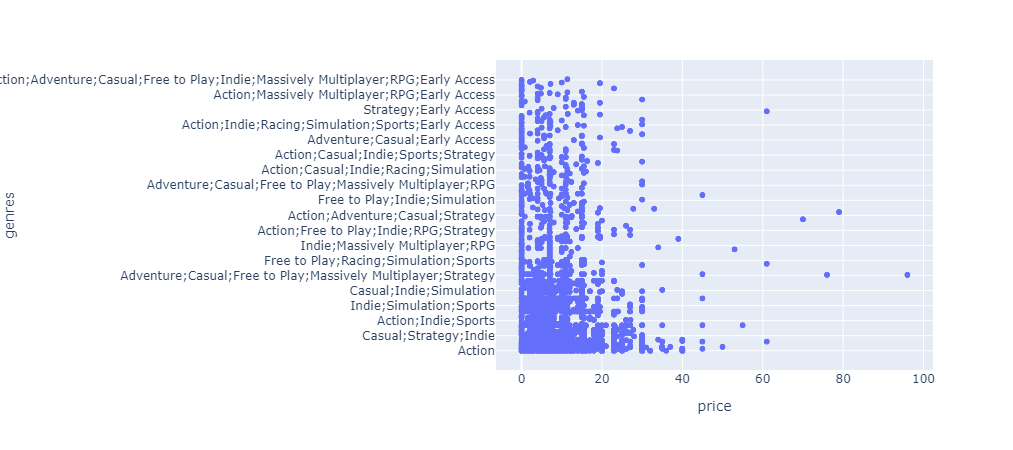

In [16]:
import plotly.express as px
import plotly as plt
plt.offline.init_notebook_mode(connected=True)

fig = px.scatter(df_clean, x='price', y='genres',
          hover_name=df_clean['name'], size_max=50);
fig.show()
